In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import time
from collections import defaultdict

import faiss
import matplotlib.pyplot as plt
import numpy as np
import pybloomfilter as pbf
import torch as th
from pytorch_lightning import seed_everything
from ranking_metrics_torch.cumulative_gain import ndcg_at
from ranking_metrics_torch.precision_recall import precision_at, recall_at
from torch_factorization_models.movielens import MovielensDataModule
from tqdm import tqdm

from practicalrecs_examples.ann_search import *
from practicalrecs_examples.dithering import *
from practicalrecs_examples.filtering import *
from practicalrecs_examples.matrix_factorization import *
from practicalrecs_examples.notebooks.utils import *
from practicalrecs_examples.pipeline import *

In [3]:
# Useful for troubleshooting CUDA errors
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# same seed used to create splits in training
random_seed = seed_everything(42)  

In [5]:
# CUDA device id
# gpu_id = th.cuda.device_count() - 1
gpu_id = 1
device_id = f"cuda:{gpu_id}"

if th.cuda.is_available():
    gpu_res = faiss.StandardGpuResources()

In [6]:
# Set default parameters
num_candidates = 250
num_recs = 100
dithering_eps = 3.0

In [7]:
# Registries for pipelines and their elements
models = {}
bloom_filters = {}
ann_indices = defaultdict(dict)
pipelines = defaultdict(dict)
builders = defaultdict(dict)
metrics = defaultdict(dict)
stages = defaultdict(dict)

### Load the dataset

In [8]:
movielens_module = MovielensDataModule("../datasets/ml-25m/", batch_size=512)
movielens_module.setup()

if th.cuda.is_available():
    movielens_module.dataset.to_(device=device_id)

In [9]:
val_dataloader = movielens_module.val_dataloader(by_user=True)

In [10]:
train_dataloader = movielens_module.train_dataloader(by_user=True)

### Build Bloom Filters

In [11]:
bloom_filters["cap10-fp0.1"] = build_bloom_filters(
    tqdm(train_dataloader.dataset),
    expected_items=10,
    fp_rate=0.1
)

100%|██████████| 162342/162342 [00:47<00:00, 3448.72it/s]


### Evaluate Model With Binary Cross-Entropy Loss

#### Load the model

In [12]:
models["bce"] = load_model("../models/celestial-bee-469-bce.pt")

if th.cuda.is_available():
    models["bce"] = models["bce"].cuda(gpu_id)

In [13]:
num_users = models["bce"].hparams.num_users
num_items = models["bce"].hparams.num_items

#### Compute Raw Model-Only Metrics

In [14]:
model_metrics = models["bce"].compute_validation_metrics(
    models["bce"].eval_predict,
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [01:34<00:00,  3.36it/s]


In [15]:
print_metrics(model_metrics)

Precision: 0.0283
Recall: 0.4900
NDCG: 0.2237


#### Build Nearest Neighbor Search Indices

In [16]:
dim = models["bce"].hparams.embedding_dim
bce_item_vectors = np.array(models["bce"].item_embeddings.weight.cpu().data)

In [17]:
ann_indices["bce"]["exact"] = build_nn_search_index(bce_item_vectors, dim, "Flat")

In [18]:
ann_indices["bce"]["approx"] = build_nn_search_index(
    bce_item_vectors, dim, "IVF1024,PQ32", nprobe=30
)

In [19]:
if th.cuda.is_available():
    cloner_options = faiss.GpuClonerOptions()
    ann_indices["bce"]["exact"] = faiss.index_cpu_to_gpu(gpu_res, gpu_id, ann_indices["bce"]["exact"], cloner_options)
    ann_indices["bce"]["approx"] = faiss.index_cpu_to_gpu(gpu_res, gpu_id, ann_indices["bce"]["approx"], cloner_options)

#### Evaluate The End-To-End Pipeline

In [20]:
builders["bce"]["base"] = RecsPipelineBuilder(
    defaults = RecsPipelineStages(
        retrieval = [
            UserAvgEmbeddingFetcher(models["bce"]),
            ANNSearch(ann_indices["bce"]["approx"], num_items, num_candidates),
        ],
        filtering = [
            BloomFilter(bloom_filters["cap10-fp0.1"]),
            CandidatePadding(num_items, num_candidates),
        ],
        scoring = [
            # Re-fetching user avg embeddings keeps retrieval changes from affecting scoring
            UserAvgEmbeddingFetcher(models["bce"]),
            MatrixFactorizationScoring(models["bce"]),
        ],
        ordering = [
            DitheredOrdering(num_candidates, num_recs, epsilon=dithering_eps),
        ]
    )
)

pipelines["bce"]["base"] = builders["bce"]["base"].build()

In [21]:
metrics["bce"]["base"] = models["bce"].compute_validation_metrics(
    build_prediction_fn(pipelines["bce"]["base"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [05:31<00:00,  1.04s/it]


In [22]:
print_metrics(metrics["bce"]["base"])

Precision: 0.0059
Recall: 0.1289
NDCG: 0.1101


In [23]:
gpu_res.getMemoryInfo()

{1: {'FlatData': (4, 5528432),
  'IVFLists': (2048, 1638528),
  'Quantizer': (2, 65536),
  'TemporaryMemoryBuffer': (1, 1610612736)}}

In [24]:
# ann_indices["bce"]["exact"].reset()
# ann_indices["bce"]["approx"].reset()

In [25]:
# del ann_indices["bce"]
# del pipelines["bce"]
# del builders["bce"]

### Evaluate Idealized Everything

In [26]:
pipelines["bce"]["ideal"] = builders["bce"]["base"].build(
    overrides = RecsPipelineStages(
        retrieval = [
            UserEmbeddingFetcher(models["bce"]),
            IdealizedANNSearch(val_dataloader.dataset, ann_indices["bce"]["exact"], num_items, num_candidates),
        ],
        filtering = [
            IdealizedFilter(train_dataloader.dataset),
            CandidatePadding(num_items, num_candidates),
        ],
        scoring = [
            # Re-fetching user avg embeddings keeps retrieval changes from affecting scoring
            UserAvgEmbeddingFetcher(models["bce"]),
            IdealizedMatrixFactorizationScoring(models["bce"], val_dataloader.dataset),
        ],
        ordering = []
    )
)

In [27]:
metrics["bce"]["ideal"] = models["bce"].compute_validation_metrics(
    build_prediction_fn(pipelines["bce"]["ideal"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

  0%|          | 0/318 [00:00<?, ?it/s]/home/karl/Projects/practicalrecs-examples/practicalrecs_examples/filtering.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  candidates = th.tensor(user_recs.candidates, dtype=th.long)
100%|██████████| 318/318 [06:05<00:00,  1.15s/it]


In [28]:
print_metrics(metrics["bce"]["ideal"])

Precision: 0.0831
Recall: 0.9996
NDCG: 0.9999


### Evaluate Idealized Retrieval

#### Learned user embedding, exact NN search, idealized results

In [29]:
stages["bce"]["ideal-retrieval"] = RecsPipelineStages(
    retrieval = [
        UserEmbeddingFetcher(models["bce"]),
        IdealizedANNSearch(val_dataloader.dataset, ann_indices["bce"]["exact"], num_items, num_candidates),
    ]
)

pipelines["bce"]["ideal-retrieval"] = builders["bce"]["base"].build(
    overrides = stages["bce"]["ideal-retrieval"]
)

In [30]:
metrics["bce"]["ideal-retrieval"] = models["bce"].compute_validation_metrics(
    build_prediction_fn(pipelines["bce"]["ideal-retrieval"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [06:08<00:00,  1.16s/it]


In [31]:
print_metrics(metrics["bce"]["ideal-retrieval"])

Precision: 0.0164
Recall: 0.3526
NDCG: 0.1687


### Evaluate Idealized Filtering

In [32]:
stages["bce"]["ideal-filtering"] = RecsPipelineStages(
    filtering = [
        IdealizedFilter(train_dataloader.dataset),
        CandidatePadding(num_items, num_candidates),
    ]
)

pipelines["bce"]["ideal-filtering"] = builders["bce"]["base"].build(
    overrides = stages["bce"]["ideal-filtering"]
)

In [33]:
metrics["bce"]["ideal-filtering"] = models["bce"].compute_validation_metrics(
    build_prediction_fn(pipelines["bce"]["ideal-filtering"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [05:57<00:00,  1.12s/it]


In [34]:
print_metrics(metrics["bce"]["ideal-filtering"])

Precision: 0.0111
Recall: 0.1618
NDCG: 0.1108


### Evaluate Idealized Scoring

In [35]:
stages["bce"]["ideal-scoring"] = RecsPipelineStages(
    scoring = [
        # Re-fetching user avg embeddings keeps retrieval changes from affecting scoring
        UserAvgEmbeddingFetcher(models["bce"]),
        IdealizedMatrixFactorizationScoring(models["bce"], val_dataloader.dataset),
    ]
)

pipelines["bce"]["ideal-scoring"] = builders["bce"]["base"].build(
    overrides = stages["bce"]["ideal-filtering"]
)

In [36]:
metrics["bce"]["ideal-scoring"] = models["bce"].compute_validation_metrics(
    build_prediction_fn(pipelines["bce"]["ideal-scoring"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [05:57<00:00,  1.12s/it]


In [37]:
print_metrics(metrics["bce"]["ideal-scoring"])

Precision: 0.0111
Recall: 0.1613
NDCG: 0.1110


### Evaluate Idealized Ordering

#### Order descending by score (omitting dithering)

In [38]:
stages["bce"]["ideal-ordering"] = RecsPipelineStages(ordering = [])

pipelines["bce"]["ideal-ordering"] = builders["bce"]["base"].build(
    overrides = stages["bce"]["ideal-ordering"]
)

In [39]:
metrics["bce"]["ideal-ordering"] = models["bce"].compute_validation_metrics(
    build_prediction_fn(pipelines["bce"]["ideal-ordering"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [04:31<00:00,  1.17it/s]


In [40]:
print_metrics(metrics["bce"]["ideal-ordering"])

Precision: 0.0070
Recall: 0.1504
NDCG: 0.1161


### Evaluate Improved Filtering

In [41]:
def sweep_filter_params(model, builder, capacities, error_rates):
    filter_metrics = {}

    for error_rate in error_rates:
        metrics = []

        for capacity in capacities:
            filters = build_bloom_filters(
                tqdm(train_dataloader.dataset),
                expected_items=capacity,
                fp_rate=error_rate
            )

            stages = RecsPipelineStages(
                filtering = [
                    BloomFilter(filters),
                    CandidatePadding(num_items, num_candidates),
                ]
            )

            pipeline = builder.build(overrides=stages)

            m = model.compute_validation_metrics(
                build_prediction_fn(pipeline, train_dataloader),
                tqdm(val_dataloader),
                num_recs
            )
            metrics.append((capacity, m))
        filter_metrics[error_rate] = metrics
        
    return filter_metrics

In [42]:
capacities = [100, 1000, 10000]
error_rates = [0.1, 0.01, 0.001]

bloom_filter_metrics = sweep_filter_params(
    models["bce"],
    builders["bce"]["base"],
    capacities,
    error_rates
)

100%|██████████| 318/318 [05:45<00:00,  1.09s/it]


In [43]:
filtering_plot_capacities = np.array(capacities)
filtering_plot_recalls = np.array([[m[1]['recall'].cpu().item() for m in bloom_filter_metrics[fp]] for fp in error_rates])
filtering_plot_ndcgs = np.array([[m[1]['ndcg'].cpu().item() for m in bloom_filter_metrics[fp]] for fp in error_rates])

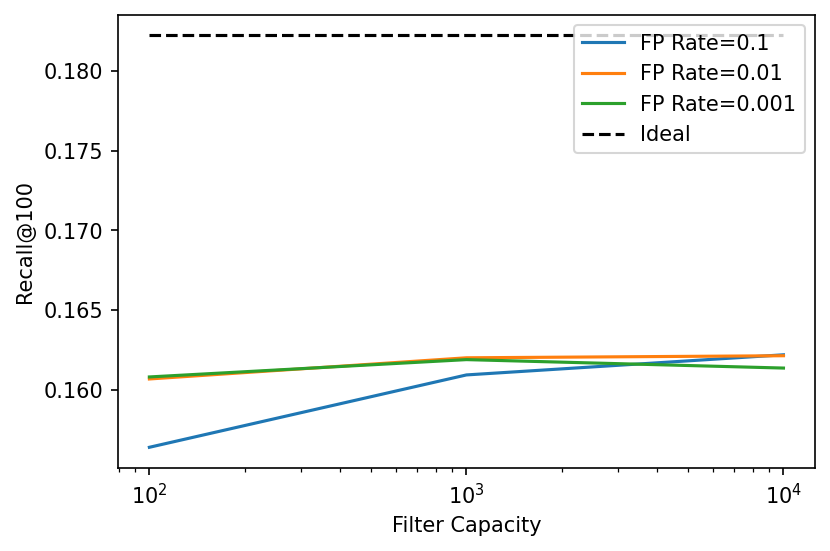

In [44]:
plt.figure(num=1, dpi=150, facecolor='w', edgecolor='k')
plt.plot(filtering_plot_capacities, filtering_plot_recalls[0], label="FP Rate=0.1")
plt.plot(filtering_plot_capacities, filtering_plot_recalls[1], label="FP Rate=0.01")
plt.plot(filtering_plot_capacities, filtering_plot_recalls[2], label="FP Rate=0.001")
plt.hlines(0.18225, filtering_plot_capacities[0], filtering_plot_capacities[-1], colors='k', linestyles='dashed', label='Ideal')
plt.xscale("log")
plt.xlabel("Filter Capacity")
plt.ylabel("Recall@100")
plt.legend()

In [45]:
import math

def compute_bytes(capacity, error_rate):
    num_hashes = max(math.floor(math.log2(1 / error_rate)), 1)
    bits_per_hash = math.ceil(
                capacity * abs(math.log(error_rate)) /
                (num_hashes * (math.log(2) ** 2)))
    num_bits = max(num_hashes * bits_per_hash,128)
    return num_bits//8

def compute_kbytes(capacity, error_rate):
    return compute_bytes(capacity, error_rate)/1024

In [46]:
bloom_filter_sizes = {}

error_rates = [0.1, 0.01, 0.001]
capacities = [100, 300, 500, 1000, 3000, 5000, 10000]

for error_rate in error_rates:
    filter_sizes = []
    
    for capacity in capacities:
        size = compute_kbytes(capacity, error_rate)
        filter_sizes.append((capacity, size))
    bloom_filter_sizes[error_rate] = filter_sizes

In [47]:
filtering_plot_capacities = np.array(capacities)
filtering_plot_sizes = np.array([[s[1] for s in bloom_filter_sizes[fp]] for fp in error_rates])

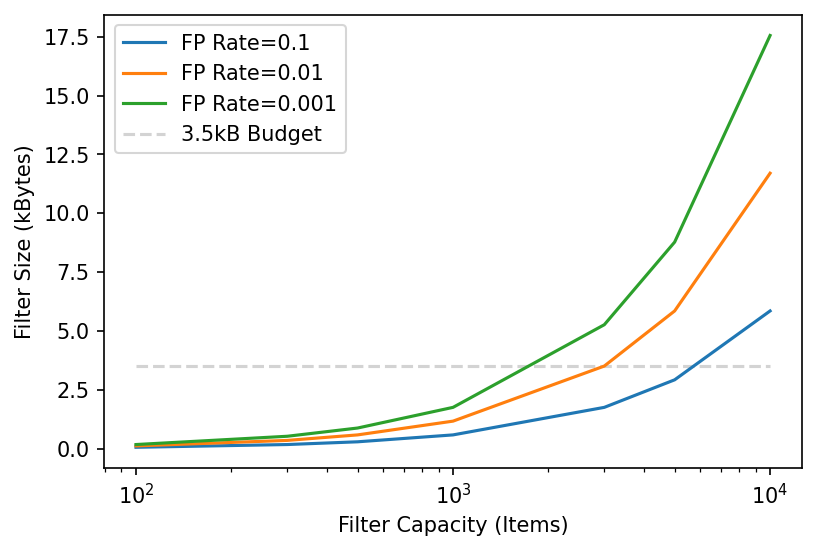

In [48]:
plt.figure(num=1, dpi=150, facecolor='w', edgecolor='k')
plt.plot(filtering_plot_capacities, filtering_plot_sizes[0], label="FP Rate=0.1")
plt.plot(filtering_plot_capacities, filtering_plot_sizes[1], label="FP Rate=0.01")
plt.plot(filtering_plot_capacities, filtering_plot_sizes[2], label="FP Rate=0.001")
plt.hlines(3.5, filtering_plot_capacities[0], filtering_plot_capacities[-1], colors='lightgray', linestyles='dashed', label='3.5kB Budget')
plt.xscale("log")
plt.xlabel("Filter Capacity (Items)")
plt.ylabel("Filter Size (kBytes)")
plt.legend()

#### New Baseline For Further Improvements

In [49]:
bloom_filters["cap5000-fp0.1"] = build_bloom_filters(
    tqdm(train_dataloader.dataset),
    expected_items=5000,
    fp_rate=0.1
)

100%|██████████| 162342/162342 [00:48<00:00, 3373.87it/s]


In [50]:
builders["bce"]["improved-filtering"] = RecsPipelineBuilder(
    defaults = RecsPipelineStages(
        retrieval = [
            UserAvgEmbeddingFetcher(models["bce"]),
            ANNSearch(ann_indices["bce"]["approx"], num_items, num_candidates),
        ],
        filtering = [
            BloomFilter(bloom_filters["cap5000-fp0.1"]),
            CandidatePadding(num_items, num_candidates),
        ],
        scoring = [
            # Re-fetching user avg embeddings keeps retrieval changes from affecting scoring
            UserAvgEmbeddingFetcher(models["bce"]),
            MatrixFactorizationScoring(models["bce"]),
        ],
        ordering = [
            DitheredOrdering(num_candidates, num_recs, epsilon=dithering_eps),
        ]
    )
)

#### Re-evaluate Idealized Stages

In [51]:
pipelines["bce"]["ideal-retrieval-w-imp-filtering"] = \
    builders["bce"]["improved-filtering"].build(overrides=stages["bce"]["ideal-retrieval"])

In [52]:
metrics["bce"]["ideal-retrieval-w-imp-filtering"] = models["bce"].compute_validation_metrics(
    build_prediction_fn(pipelines["bce"]["ideal-retrieval-w-imp-filtering"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [06:08<00:00,  1.16s/it]


In [53]:
print_metrics(metrics["bce"]["ideal-retrieval-w-imp-filtering"])

Precision: 0.0391
Recall: 0.4693
NDCG: 0.2201


In [54]:
pipelines["bce"]["ideal-scoring-w-imp-filtering"] = \
    builders["bce"]["improved-filtering"].build(overrides=stages["bce"]["ideal-scoring"])

In [55]:
metrics["bce"]["ideal-scoring-w-imp-filtering"] = models["bce"].compute_validation_metrics(
    build_prediction_fn(pipelines["bce"]["ideal-scoring-w-imp-filtering"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [06:19<00:00,  1.19s/it]


In [56]:
print_metrics(metrics["bce"]["ideal-scoring-w-imp-filtering"])

Precision: 0.0216
Recall: 0.3235
NDCG: 0.4237


In [57]:
pipelines["bce"]["ideal-ordering-w-imp-filtering"] = \
    builders["bce"]["improved-filtering"].build(overrides=stages["bce"]["ideal-ordering"])

In [58]:
metrics["bce"]["ideal-ordering-w-imp-filtering"] = models["bce"].compute_validation_metrics(
    build_prediction_fn(pipelines["bce"]["ideal-ordering-w-imp-filtering"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [04:42<00:00,  1.13it/s]


In [59]:
print_metrics(metrics["bce"]["ideal-ordering-w-imp-filtering"])

Precision: 0.0126
Recall: 0.1822
NDCG: 0.1180


### Evaluate Model With BPR

#### Load the model

In [60]:
models["bpr"] = load_model("../models/pious-meadow-467-bpr.pt")

if th.cuda.is_available():
    models["bpr"] = models["bpr"].cuda(gpu_id)

In [61]:
num_users = models["bpr"].hparams.num_users
num_items = models["bpr"].hparams.num_items

#### Compute Raw Model-Only Metrics

In [62]:
metrics["bpr"]["base"] = models["bpr"].compute_validation_metrics(
    models["bpr"].eval_predict,
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [01:38<00:00,  3.22it/s]


In [63]:
print_metrics(metrics["bpr"]["base"])

Precision: 0.0297
Recall: 0.5003
NDCG: 0.2307


#### Build Nearest Neighbor Search Indices

In [64]:
dim = models["bpr"].hparams.embedding_dim
bpr_item_vectors = np.array(models["bpr"].item_embeddings.weight.cpu().data)

In [65]:
ann_indices["bpr"]["exact"] = build_nn_search_index(bpr_item_vectors, dim, "Flat")

In [66]:
ann_indices["bpr"]["approx"] = build_nn_search_index(
    bpr_item_vectors, dim, "IVF1024,PQ32", nprobe=30
)

In [67]:
if th.cuda.is_available():
    cloner_options = faiss.GpuClonerOptions()
    ann_indices["bpr"]["exact"] = faiss.index_cpu_to_gpu(gpu_res, gpu_id, ann_indices["bpr"]["exact"], cloner_options)
    ann_indices["bpr"]["approx"] = faiss.index_cpu_to_gpu(gpu_res, gpu_id, ann_indices["bpr"]["approx"], cloner_options)

In [68]:
gpu_res.getMemoryInfo()

{1: {'FlatData': (8, 11056864),
  'IVFLists': (4096, 3277040),
  'Quantizer': (4, 131072),
  'TemporaryMemoryBuffer': (1, 1610612736)}}

#### Evaluate The End-To-End Pipelines

In [69]:
stages["bpr"]["improved-scoring"] = RecsPipelineStages(
    scoring = [
        # Re-fetching user avg embeddings keeps retrieval changes from affecting scoring
        UserAvgEmbeddingFetcher(models["bpr"]),
        MatrixFactorizationScoring(models["bpr"]),
    ],
)

pipelines["bpr"]["improved-scoring"] = builders["bce"]["improved-filtering"].build(
    overrides = stages["bpr"]["improved-scoring"]
)

In [70]:
metrics["bpr"]["improved-scoring"] = models["bpr"].compute_validation_metrics(
    build_prediction_fn(pipelines["bpr"]["improved-scoring"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [05:40<00:00,  1.07s/it]


In [71]:
print_metrics(metrics["bpr"]["improved-scoring"])

Precision: 0.0096
Recall: 0.1301
NDCG: 0.0944


In [72]:
stages["bpr"]["improved-scoring-retrieval"] = RecsPipelineStages(
    retrieval = [
        UserAvgEmbeddingFetcher(models["bpr"]),
        ANNSearch(ann_indices["bpr"]["approx"], num_items, num_candidates),
    ],
    scoring = [
        # Re-fetching user avg embeddings keeps retrieval changes from affecting scoring
        UserAvgEmbeddingFetcher(models["bpr"]),
        MatrixFactorizationScoring(models["bpr"]),
    ],
)

pipelines["bpr"]["improved-scoring-retrieval"] = \
    builders["bce"]["improved-filtering"].build(
        overrides=stages["bpr"]["improved-scoring-retrieval"]
    )

In [73]:
metrics["bpr"]["improved-scoring-retrieval"] = models["bpr"].compute_validation_metrics(
    build_prediction_fn(pipelines["bpr"]["improved-scoring-retrieval"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [05:40<00:00,  1.07s/it]


In [74]:
print_metrics(metrics["bpr"]["improved-scoring-retrieval"])

Precision: 0.0139
Recall: 0.1783
NDCG: 0.1155


### Evaluate Model With WARP Loss

In [75]:
models["warp"] = load_model("../models/good-sweep-1-warp-01.pt")

if th.cuda.is_available():
    models["warp"] = models["warp"].cuda(gpu_id)

#### Build Nearest Neighbor Search Indices

In [76]:
dim = models["warp"].hparams.embedding_dim
warp_item_vectors = np.array(models["warp"].item_embeddings.weight.cpu().data)

In [77]:
ann_indices["warp"]["exact"] = build_nn_search_index(warp_item_vectors, dim, "Flat")

In [78]:
ann_indices["warp"]["approx"] = build_nn_search_index(
    warp_item_vectors, dim, "IVF1024,PQ32", nprobe=30
)

In [79]:
if th.cuda.is_available():
    cloner_options = faiss.GpuClonerOptions()
    ann_indices["warp"]["exact"] = faiss.index_cpu_to_gpu(gpu_res, gpu_id, ann_indices["warp"]["exact"], cloner_options)
    ann_indices["warp"]["approx"] = faiss.index_cpu_to_gpu(gpu_res, gpu_id, ann_indices["warp"]["approx"], cloner_options)

#### Compute Raw Model-Only Metrics

In [80]:
metrics["warp"]["base"] = models["warp"].compute_validation_metrics(
    models["warp"].eval_predict,
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [01:38<00:00,  3.22it/s]


In [81]:
print_metrics(metrics["warp"]["base"])

Precision: 0.0312
Recall: 0.5171
NDCG: 0.2403


#### Evaluate The End-To-End Pipelines

In [82]:
num_users = models["warp"].hparams.num_users
num_items = models["warp"].hparams.num_items

In [83]:
stages["warp"]["improved-scoring"] = RecsPipelineStages(
    scoring = [
        # Re-fetching user avg embeddings keeps retrieval changes from affecting scoring
        UserAvgEmbeddingFetcher(models["warp"]),
        MatrixFactorizationScoring(models["warp"]),
    ],
)

pipelines["warp"]["improved-scoring"] = \
    builders["bce"]["improved-filtering"].build(
        overrides=stages["warp"]["improved-scoring"]
    )

In [84]:
metrics["warp"]["improved-scoring"] = models["warp"].compute_validation_metrics(
    build_prediction_fn(pipelines["warp"]["improved-scoring"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [06:00<00:00,  1.13s/it]


In [85]:
print_metrics(metrics["warp"]["improved-scoring"])

Precision: 0.0152
Recall: 0.2337
NDCG: 0.1673


In [86]:
stages["warp"]["improved-scoring-retrieval"] = RecsPipelineStages(
    retrieval = [
        UserAvgEmbeddingFetcher(models["warp"]),
        ANNSearch(ann_indices["warp"]["approx"], num_items, num_candidates),
    ],
    scoring = [
        # Re-fetching user avg embeddings keeps retrieval changes from affecting scoring
        UserAvgEmbeddingFetcher(models["warp"]),
        MatrixFactorizationScoring(models["warp"]),
    ],
)

pipelines["warp"]["improved-scoring-retrieval"] = \
    builders["bce"]["improved-filtering"].build(
        overrides=stages["warp"]["improved-scoring-retrieval"]
    )

In [87]:
metrics["warp"]["improved-scoring-retrieval"] = models["warp"].compute_validation_metrics(
    build_prediction_fn(pipelines["warp"]["improved-scoring-retrieval"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [06:00<00:00,  1.13s/it]


In [88]:
print_metrics(metrics["warp"]["improved-scoring-retrieval"])

Precision: 0.0192
Recall: 0.2520
NDCG: 0.1555


#### New Baseline For Further Improvements

In [89]:
stages["warp"]["improved-scoring-base"] = RecsPipelineStages(
    retrieval = [
        UserAvgEmbeddingFetcher(models["warp"]),
        ANNSearch(ann_indices["warp"]["approx"], num_items, num_candidates),
    ],
    filtering = [
        BloomFilter(bloom_filters["cap5000-fp0.1"]),
        CandidatePadding(num_items, num_candidates),
    ],
    scoring = [
        # Re-fetching user avg embeddings keeps retrieval changes from affecting scoring
        UserAvgEmbeddingFetcher(models["warp"]),
        MatrixFactorizationScoring(models["warp"]),
    ],
    ordering = [
        DitheredOrdering(num_candidates, num_recs, epsilon=dithering_eps),
    ]
)

builders["warp"]["improved-scoring-base"] = \
    RecsPipelineBuilder(defaults=stages["warp"]["improved-scoring-base"])

#### Re-evaluate Idealized Stages

In [90]:
stages["warp"]["ideal-retrieval"] = RecsPipelineStages(
    retrieval = [
        UserEmbeddingFetcher(models["warp"]),
        IdealizedANNSearch(val_dataloader.dataset, ann_indices["warp"]["exact"], num_items, num_candidates),
    ]
)

pipelines["warp"]["ideal-retrieval"] = builders["warp"]["improved-scoring-base"].build(
    overrides=stages["warp"]["ideal-retrieval"]
)

In [91]:
metrics["warp"]["ideal-retrieval"] = models["warp"].compute_validation_metrics(
    build_prediction_fn(pipelines["warp"]["ideal-retrieval"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [06:20<00:00,  1.20s/it]


In [92]:
print_metrics(metrics["warp"]["ideal-retrieval"])

Precision: 0.0410
Recall: 0.5071
NDCG: 0.2458


In [93]:
pipelines["warp"]["ideal-ordering"] = builders["warp"]["improved-scoring-base"].build(
    overrides=stages["bce"]["ideal-ordering"]
)

In [94]:
metrics["warp"]["ideal-ordering"] = models["warp"].compute_validation_metrics(
    build_prediction_fn(pipelines["warp"]["ideal-ordering"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [04:41<00:00,  1.13it/s]


In [95]:
print_metrics(metrics["warp"]["ideal-ordering"])

Precision: 0.0228
Recall: 0.2979
NDCG: 0.1704


### Improved Retrieval

#### Learned user embedding, exact NN search, no idealization

In [96]:
stages["warp"]["learned-exact-retrieval"] = RecsPipelineStages(
    retrieval = [
        UserEmbeddingFetcher(models["warp"]),
        ANNSearch(ann_indices["warp"]["exact"], num_items, num_candidates),
        UserAvgEmbeddingFetcher(models["warp"])
    ]
)

pipelines["warp"]["learned-exact-retrieval"] = \
    builders["warp"]["improved-scoring-base"].build(
        overrides=stages["warp"]["learned-exact-retrieval"]
    )

In [97]:
metrics["warp"]["learned-exact-retrieval"] = models["warp"].compute_validation_metrics(
    build_prediction_fn(pipelines["warp"]["learned-exact-retrieval"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [06:00<00:00,  1.13s/it]


In [98]:
print_metrics(metrics["warp"]["learned-exact-retrieval"])

Precision: 0.0208
Recall: 0.2565
NDCG: 0.1547


#### Learned user embedding, approx NN search, no idealization

In [99]:
stages["warp"]["learned-approx-retrieval"] = RecsPipelineStages(
    retrieval = [
        UserEmbeddingFetcher(models["warp"]),
        ANNSearch(ann_indices["warp"]["approx"], num_items, num_candidates),
        UserAvgEmbeddingFetcher(models["warp"])
    ]
)

pipelines["warp"]["learned-approx-retrieval"] = \
    builders["warp"]["improved-scoring-base"].build(
        overrides=stages["warp"]["learned-approx-retrieval"]
    )

In [100]:
metrics["warp"]["learned-approx-retrieval"] = models["warp"].compute_validation_metrics(
    build_prediction_fn(pipelines["warp"]["learned-approx-retrieval"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [06:00<00:00,  1.13s/it]


In [101]:
print_metrics(metrics["warp"]["learned-approx-retrieval"])

Precision: 0.0163
Recall: 0.2107
NDCG: 0.1409


#### Averaged user embedding, exact NN search, no idealization

In [102]:
stages["warp"]["avg-exact-retrieval"] = RecsPipelineStages(
    retrieval = [
        UserAvgEmbeddingFetcher(models["warp"]),
        ANNSearch(ann_indices["warp"]["exact"], num_items, num_candidates),
    ]
)

pipelines["warp"]["avg-exact-retrieval"] = \
    builders["warp"]["improved-scoring-base"].build(
        overrides=stages["warp"]["avg-exact-retrieval"]
    )

In [103]:
metrics["warp"]["avg-exact-retrieval"] = models["warp"].compute_validation_metrics(
    build_prediction_fn(pipelines["warp"]["avg-exact-retrieval"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [06:14<00:00,  1.18s/it]


In [104]:
print_metrics(metrics["warp"]["avg-exact-retrieval"])

Precision: 0.0189
Recall: 0.2472
NDCG: 0.1533


#### Averaged user embedding, approx NN search, no idealization

In [105]:
stages["warp"]["avg-approx-retrieval"] = RecsPipelineStages(
    retrieval = [
        UserEmbeddingFetcher(models["warp"]),
        ANNSearch(ann_indices["warp"]["approx"], num_items, num_candidates),
        UserAvgEmbeddingFetcher(models["warp"])
    ]
)

pipelines["warp"]["avg-approx-retrieval"] = \
    builders["warp"]["improved-scoring-base"].build(
        overrides=stages["warp"]["avg-approx-retrieval"]
    )

In [106]:
metrics["warp"]["avg-approx-retrieval"] = models["warp"].compute_validation_metrics(
    build_prediction_fn(pipelines["warp"]["avg-approx-retrieval"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [06:04<00:00,  1.15s/it]


In [107]:
print_metrics(metrics["warp"]["avg-approx-retrieval"])

Precision: 0.0163
Recall: 0.2106
NDCG: 0.1407


####  Item embeddings, exact NN search, no idealization

In [108]:
stages["warp"]["items-exact-retrieval"] = RecsPipelineStages(
    retrieval = [
        ItemEmbeddingsFetcher(models["warp"]),
        UseItemEmbeddingsAsUserEmbeddings(),
        ANNSearch(ann_indices["warp"]["exact"], num_items, num_candidates),
    ]
)

pipelines["warp"]["items-exact-retrieval"] = \
    builders["warp"]["improved-scoring-base"].build(
        overrides=stages["warp"]["items-exact-retrieval"]
    )

In [109]:
metrics["warp"]["items-exact-retrieval"] = models["warp"].compute_validation_metrics(
    build_prediction_fn(pipelines["warp"]["items-exact-retrieval"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [07:14<00:00,  1.37s/it]


In [110]:
print_metrics(metrics["warp"]["items-exact-retrieval"])

Precision: 0.0184
Recall: 0.3193
NDCG: 0.1859


#### Item embeddings, approx NN search, no idealization

In [111]:
stages["warp"]["items-approx-retrieval"] = RecsPipelineStages(
    retrieval = [
        ItemEmbeddingsFetcher(models["warp"]),
        UseItemEmbeddingsAsUserEmbeddings(),
        ANNSearch(ann_indices["warp"]["approx"], num_items, num_candidates),
    ]
)

pipelines["warp"]["items-approx-retrieval"] = \
    builders["warp"]["improved-scoring-base"].build(
        overrides=stages["warp"]["items-approx-retrieval"]
    )

In [112]:
metrics["warp"]["items-approx-retrieval"] = models["warp"].compute_validation_metrics(
    build_prediction_fn(pipelines["warp"]["items-approx-retrieval"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [06:50<00:00,  1.29s/it]


In [113]:
print_metrics(metrics["warp"]["items-approx-retrieval"])

Precision: 0.0197
Recall: 0.3333
NDCG: 0.1893


#### New baseline for further improvements

In [114]:
stages["warp"]["improved-retrieval-base"] = RecsPipelineStages(
    retrieval = [
        ItemEmbeddingsFetcher(models["warp"]),
        UseItemEmbeddingsAsUserEmbeddings(),
        ANNSearch(ann_indices["warp"]["approx"], num_items, num_candidates),
    ],
    filtering = [
        BloomFilter(bloom_filters["cap5000-fp0.1"]),
        CandidatePadding(num_items, num_candidates),
    ],
    scoring = [
        # Re-fetching user avg embeddings keeps retrieval changes from affecting scoring
        UserAvgEmbeddingFetcher(models["warp"]),
        MatrixFactorizationScoring(models["warp"]),
    ],
    ordering = [
        DitheredOrdering(num_candidates, num_recs, epsilon=dithering_eps),
    ]
)

builders["warp"]["improved-retrieval-base"] = \
    RecsPipelineBuilder(defaults=stages["warp"]["improved-retrieval-base"])

In [115]:
pipelines["warp"]["ideal-ordering"] = \
    builders["warp"]["improved-retrieval-base"].build(
        overrides=stages["bce"]["ideal-ordering"]
    )

In [116]:
metrics["warp"]["ideal-ordering"] = models["warp"].compute_validation_metrics(
    build_prediction_fn(pipelines["warp"]["ideal-ordering"], train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

100%|██████████| 318/318 [05:32<00:00,  1.05s/it]


In [117]:
print_metrics(metrics["warp"]["ideal-ordering"])

Precision: 0.0230
Recall: 0.3995
NDCG: 0.2125


### Improved Ordering

#### Reduced dithering

In [ ]:
def float_range(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [ ]:
stages = RecsPipelineStages(
    ordering = [
        DitheredOrdering(num_recs, epsilon=5.0),
    ]
)
dithering_pipeline = builders["warp"]["improved-retrieval-base"].build(overrides=stages)
dithering_pipeline.caching = True
m = models["warp"].compute_validation_metrics(
    build_prediction_fn(dithering_pipeline, train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

In [ ]:
import copy
initial_results = dithering_pipeline.cache
dithering_pipeline.cache = {}

In [ ]:
for user_id in tqdm(initial_results.keys()):
    user_recs = copy.deepcopy(initial_results[user_id])
    user_recs = dithering_pipeline.components[-1].run(user_recs)
    dithering_pipeline.cache[user_id] = user_recs
    
rerun_results = dithering_pipeline.cache

In [ ]:
initial_results[0].scores[initial_results[0].scores != float("-inf")]

In [ ]:
rerun_results[0].scores[rerun_results[0].scores != float("-inf")]

In [ ]:
th.topk(initial_results[0].scores, num_recs)

In [ ]:
th.topk(rerun_results[0].scores, num_recs)

In [ ]:
_, initial_indices = th.topk(initial_results[0].scores, num_recs)
_, rerun_indices = th.topk(rerun_results[0].scores, num_recs)

In [ ]:
len(np.intersect1d(initial_indices, rerun_indices))

In [ ]:
overlaps = []

for user_id in tqdm(initial_results.keys()): 
    _, initial_indices = th.topk(initial_results[user_id].scores, num_recs)
    _, rerun_indices = th.topk(rerun_results[user_id].scores, num_recs)

    intersection = len(np.intersect1d(initial_indices, rerun_indices))
    overlaps.append(intersection)

In [ ]:
print(np.min(np.array(overlaps)))
print(np.max(np.array(overlaps)))
print(np.median(np.array(overlaps)))

In [ ]:
import copy

builder = improved_retrieval_pipeline_builder
ordering_epsilons = list(float_range(1.0,2.0,0.5))

metrics = []

for epsilon in ordering_epsilons:
    stages = RecsPipelineStages(
        ordering = [
            DitheredOrdering(num_recs, epsilon=epsilon),
        ]
    )
    dithering_pipeline = builder.build(overrides=stages)
    dithering_pipeline.caching = True
    m = warp_model.compute_validation_metrics(
        build_prediction_fn(dithering_pipeline, train_dataloader),
        tqdm(val_dataloader),
        num_recs
    )
    print("Finished computing metrics")
    initial_results = copy.deepcopy(dithering_pipeline.cache)
    print("Finished deep copy")
    
    # Re-run the dithering stage
    for user_id in dithering_pipeline.cache.keys():
        user_recs = dithering_pipeline.cache[user_id]
        user_recs = dithering_pipeline.components[-1].run(user_recs)
        dithering_pipeline.cache[user_id] = user_recs
        
    rerun_results = dithering_pipeline.cache
    print("Finished re-running dithering")
    
    overlaps = []
    
    for user_id in tqdm(initial_results.keys()): 
        _, initial_indices = th.topk(initial_results[user_id].scores, num_recs)
        _, rerun_indices = th.topk(rerun_results[user_id].scores, num_recs)
        
        overlaps.append(np.intersect1d(initial_indices, rerun_indices))
    print("Finished computing overlaps")
        
    m['overlap'] = np.median(np.array(overlaps))
    
    metrics.append((epsilon, m))

In [ ]:
dithering_plot_epsilons = np.array([m[0] for m in metrics])
dithering_plot_ndcgs = np.array([m[1]['ndcg'].cpu().item() for m in metrics])

In [ ]:
plt.figure(num=2, dpi=150, facecolor='w', edgecolor='k')
plt.plot(dithering_plot_epsilons, dithering_plot_ndcgs)
plt.xlabel("Dithering Epsilon")
plt.ylabel("NDCG")
plt.axvspan(1.5, 3.0, color='green', alpha=0.1, label="Typical Range")
plt.legend()

#### New Baseline For Further Improvements

In [ ]:
default_stages = RecsPipelineStages(
    retrieval = [
        ItemEmbeddingsFetcher(warp_model),
        UseItemEmbeddingsAsUserEmbeddings(),
        ANNSearch(warp_approx_index, num_items, num_candidates),
    ],
    filtering = [
        BloomFilter(improved_bloom_filters),
        CandidatePadding(num_items, num_candidates),
    ],
    scoring = [
        # Re-fetching user average embeddings keeps modified retrieval from affecting scoring
        UserAvgEmbeddingFetcher(warp_model),
        MatrixFactorizationScoring(warp_model),
    ],
    ordering = [
        DitheredOrdering(num_recs, epsilon=2.0),
    ]
)

improved_ordering_pipeline_builder = RecsPipelineBuilder(defaults=default_stages)

### Evaluate Idealized Retrieval

In [ ]:
builder = improved_ordering_pipeline_builder

#### Learned user embedding, exact NN search, idealized results

In [ ]:
ideal_retrieval_stages = RecsPipelineStages(
    retrieval = [
        UserEmbeddingFetcher(warp_model),
        IdealizedANNSearch(val_dataloader.dataset, bce_exact_index, num_items, num_candidates),
    ]
)

ideal_retrieval = builder.build(overrides=ideal_retrieval_stages)

In [ ]:
ideal_retrieval_metrics = warp_model.compute_validation_metrics(
    build_prediction_fn(ideal_retrieval, train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

In [ ]:
print_metrics(ideal_retrieval_metrics)

### Evaluate Idealized Filtering

In [ ]:
ideal_filtering_stages = RecsPipelineStages(
    filtering = [
        IdealizedFilter(train_dataloader.dataset),
        CandidatePadding(num_items, num_candidates),
    ]
)

ideal_filtering = builder.build(overrides=ideal_filtering_stages)

In [ ]:
ideal_filtering_metrics = warp_model.compute_validation_metrics(
    build_prediction_fn(ideal_filtering, train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

In [ ]:
print_metrics(ideal_filtering_metrics)

### Evaluate Idealized Scoring

In [ ]:
ideal_scoring_stages = RecsPipelineStages(
    scoring = [
        # Re-fetching user avg embeddings keeps retrieval changes from affecting scoring
        UserAvgEmbeddingFetcher(warp_model),
        IdealizedMatrixFactorizationScoring(warp_model, val_dataloader.dataset),
    ]
)

ideal_scoring = builder.build(overrides=ideal_scoring_stages)

In [ ]:
ideal_scoring_metrics = warp_model.compute_validation_metrics(
    build_prediction_fn(ideal_scoring, train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

In [ ]:
print_metrics(ideal_scoring_metrics)

### Evaluate Idealized Ordering

#### Order descending by score (omitting dithering)

In [ ]:
ideal_ordering_stages = RecsPipelineStages(ordering = [])

ideal_ordering = builder.build(overrides=ideal_ordering_stages)

In [ ]:
ideal_ordering_metrics = warp_model.compute_validation_metrics(
    build_prediction_fn(ideal_ordering, train_dataloader),
    tqdm(val_dataloader),
    num_recs
)

In [ ]:
print_metrics(ideal_ordering_metrics)